In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_07/'

In [6]:
!cp drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_05/train_utils.py train_utils.py

## Семинар 7: "Методы оптимизации"

ФИО: Иванов Максим Юрьевич


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [9]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()      
  
    def step(self, F):
        loss = F()
        loss.backward()


class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad


class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v


class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma

    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v


class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 10
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad


class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)

        self.learning_rate = learning_rate

        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8

    def step(self, F):
        super().step(F)

        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(g + param.grad ** 2)
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad


class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)

        self.learning_rate = learning_rate

        self.m_list = [torch.zeros_like(param) for param in self.parameters]
        self.nu_list = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.iter = 0

    def step(self, F):
        super().step(F)

        with torch.no_grad():
            self.iter += 1
            for m, nu, param in zip(self.m_list, self.nu_list, self.parameters):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                nu.copy_(self.beta2 * nu + (1 - self.beta2) * param.grad ** 2)

                nu_a = nu / (1 - self.beta2 ** self.iter)
                m_a = m / (1 - self.beta1 ** self.iter)
                param -= (self.learning_rate *  m_a / torch.sqrt(nu_a + self.eps))

In [63]:
def get_variable(val=0):
    x = np.array([float(val)])
    x = torch.from_numpy(x)
    return Variable(x, requires_grad=True)

In [64]:
def compare_optimizers(J, start_point=None, learning_rate=0.01, plot_point_xy=None, verbose=False, plot=True):
    start_point = start_point or [2.5, 1.5]
    plot_point_xy = plot_point_xy or [-5, 5,-5, 5]
    
    optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adam]
    colors = ['r', 'b', 'y', 'pink', 'orange', 'g']

    optim_path = []

    for optim in optimizers:
        if verbose:
            print(optim.__name__)

        x = get_variable(start_point[0])
        y = get_variable(start_point[1])
        optim = optim([x, y], learning_rate=learning_rate)
        
        points = []
        
        for i in range(20):
            p_z = J(x, y).item()
            p_x = x.item()
            p_y = y.item()
            if verbose:
                print(p_z, p_x, p_y)
            points.append((p_x, p_y, p_z))

            optim.step(lambda: J(x, y))
            optim.zero_grad()
            
        optim_path.append(np.array(points))
    
    if plot:
        fig = plt.figure(figsize=(14, 9))
        ax = fig.add_subplot(111, projection='3d')

        for color, path, optim in zip(colors, optim_path, optimizers):
            name = optim.__name__
            points = np.array(path)
            points += np.random.rand(3) * 0.04
            ax.plot(points[:, 0], points[:, 1], points[:, 2], 
                    color=color, linewidth=5, label=name)
        plt.legend()
        plt.show()


        plt.figure(figsize=(15, 10))
        for i, optim in enumerate(optimizers):
            name = optim.__name__
            color = colors[i]
            plt.scatter(optim_path[i][:, 0], optim_path[i][:, 1], c=color)
            plt.plot(optim_path[i][:, 0], optim_path[i][:, 1], c=color, label=name)
        
        X = np.linspace(plot_point_xy[0], plot_point_xy[1], 100)
        Y = np.linspace(plot_point_xy[2], plot_point_xy[3], 100)
        X, Y = np.meshgrid(X, Y)
        Z = J(torch.tensor(X), torch.tensor(Y))
        con = plt.contour(X, Y, Z, colors='k')
        plt.clabel(con)
        axes = plt.gca()
        axes.set_xlim([plot_point_xy[0], plot_point_xy[1]])
        axes.set_ylim([plot_point_xy[2], plot_point_xy[3]])
        plt.legend()
        plt.show()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

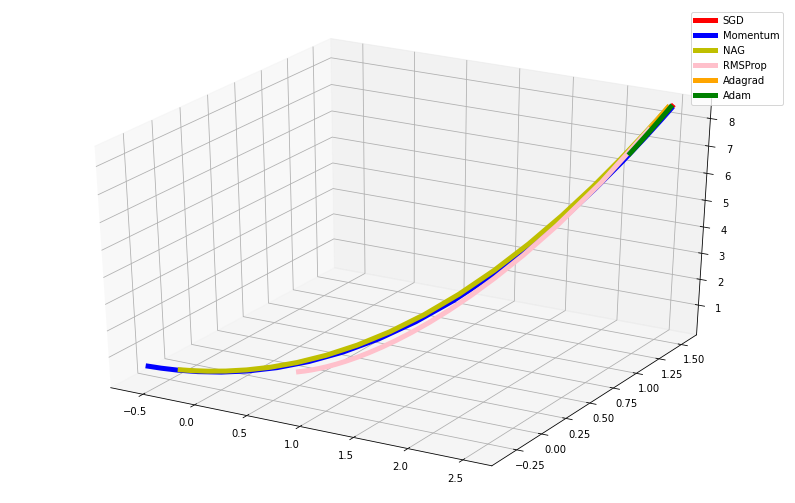

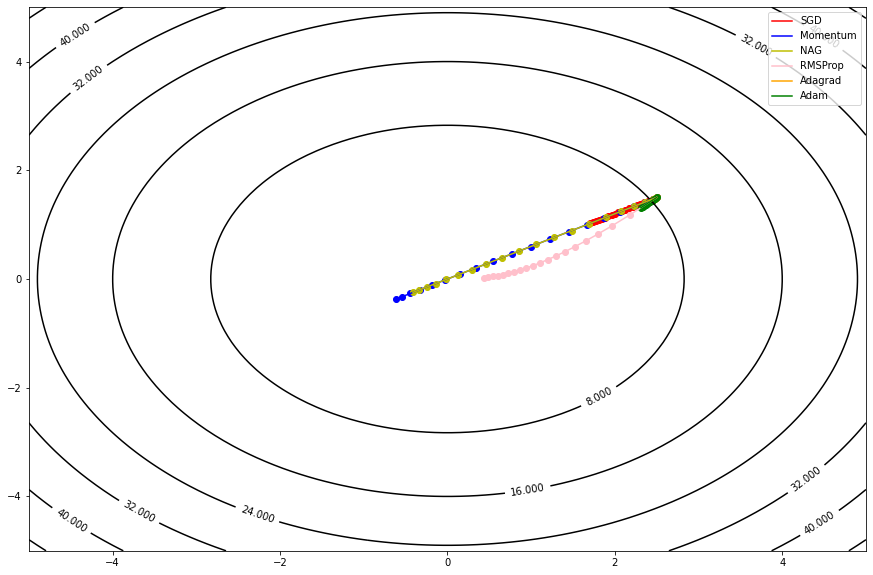

In [65]:
def J(x, y):
    return x ** 2 + y ** 2

compare_optimizers(J)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

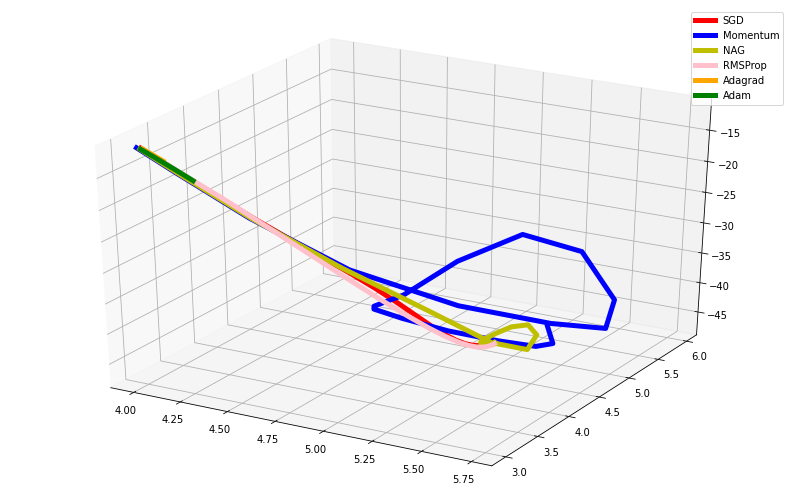

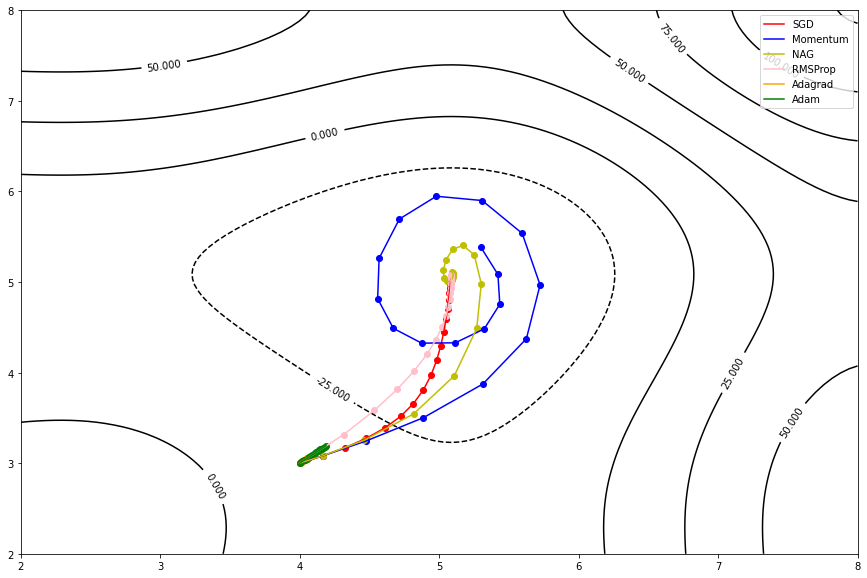

In [66]:
def J(x, y):
    return torch.sin(x) * x ** 2 + torch.sin(y) * y ** 2

compare_optimizers(J, start_point=[4, 3], plot_point_xy=[2, 8, 2, 8])

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

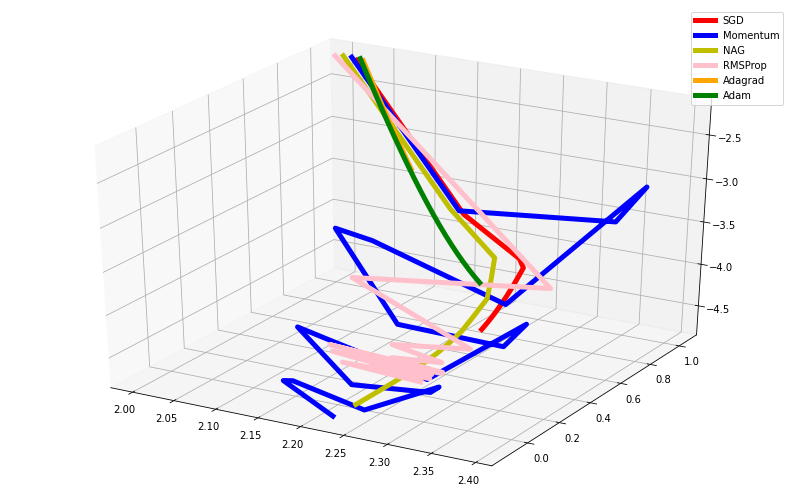

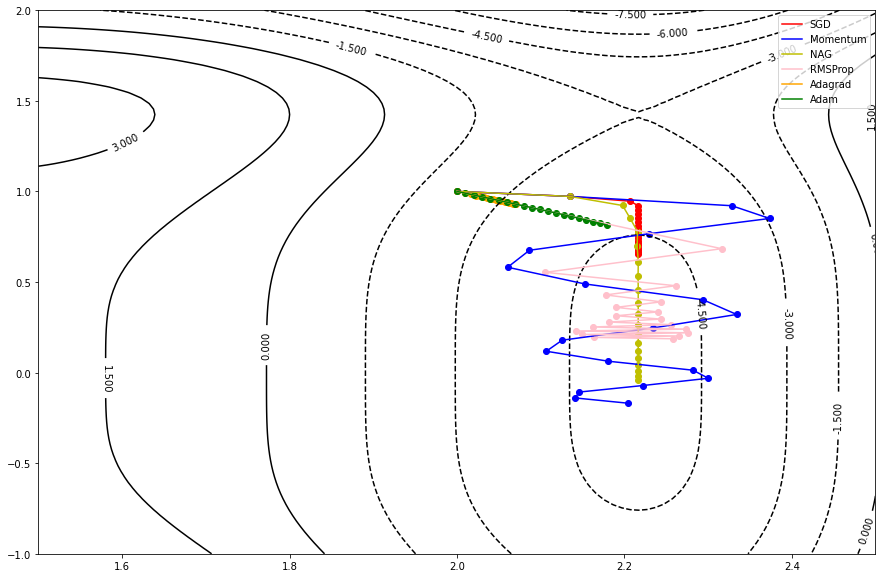

In [67]:
def J(x, y):
    x2 = x ** 2
    y2 = y ** 2
    return torch.sin(x2) * x2 + torch.sin(y2) * y2

compare_optimizers(J, start_point=[2, 1], plot_point_xy=[1.5, 2.5,-1, 2])

###  Часть 2: Обучение нейронной сети

In [ ]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [44]:
from train_utils import get_loaders, plot_comp
from IPython.display import clear_output

In [73]:
def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            # loss_batch.backward()
            optimizer.step(lambda: loss(prediction, y))
        prediction = prediction.max(1)[1]
        accuracies.append((prediction == y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader=None, test_loader=None, epochs=5, 
          learning_rate=1e-3, plot=True, verbose=True, loss=None, 
          optimizer=None, clear_data=True,
          ravel_init=False, device='cpu', tolerate_keyboard_interrupt=True):
    loss = loss() if loss else nn.NLLLoss()
    optimizer = optimizer(network.parameters(), learning_rate) if optimizer else torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loader = train_loader or base_train_loader
    test_loader = test_loader or base_test_loader
    
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            if verbose:
                if clear_data:
                    clear_output(True)
                print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [74]:
base_train_loader, base_test_loader = get_loaders(download=True)
train_loader, test_loader = base_train_loader, base_test_loader

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [75]:
def get_nn():
    return nn.Sequential(
        nn.Linear(28 * 28, 128), nn.ReLU(),
        nn.Linear(128, 128), nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(1)
    )

In [76]:
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
networks = {}
optimizers = {
    'SGD': SGD,
    'Adagrad': Adagrad,
    'RMSProp': RMSProp,
    'Adam': Adam
}

Epoch 4... (Train/Test) NLL: 0.358/0.325	Accuracy: 0.899/0.908


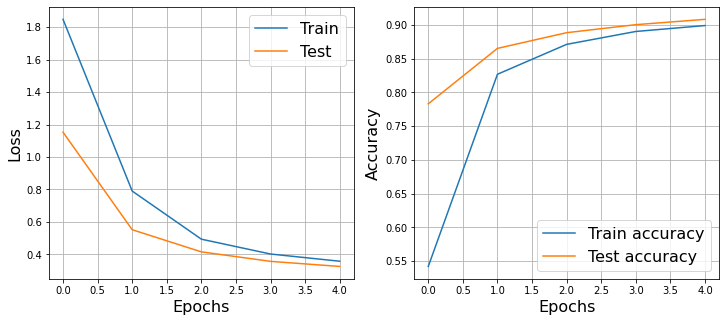

CPU times: user 1min 17s, sys: 472 ms, total: 1min 18s
Wall time: 1min 18s


In [77]:
%%time
name = 'SGD'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name], 
    ravel_init=True
)

Epoch 4... (Train/Test) NLL: 0.259/0.249	Accuracy: 0.925/0.927


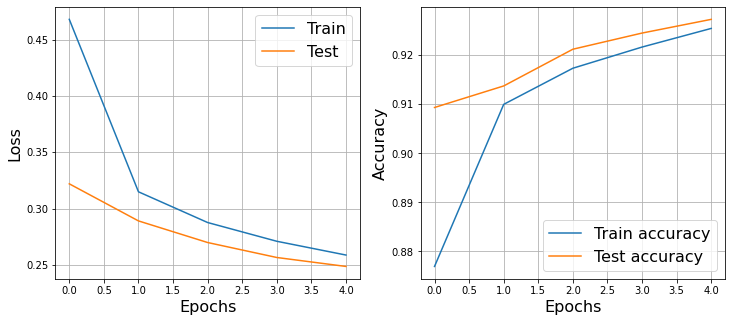

CPU times: user 1min 29s, sys: 830 ms, total: 1min 30s
Wall time: 1min 31s


In [78]:
%%time
name = 'Adagrad'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name], 
    ravel_init=True
)

Epoch 4... (Train/Test) NLL: 0.615/0.684	Accuracy: 0.898/0.854


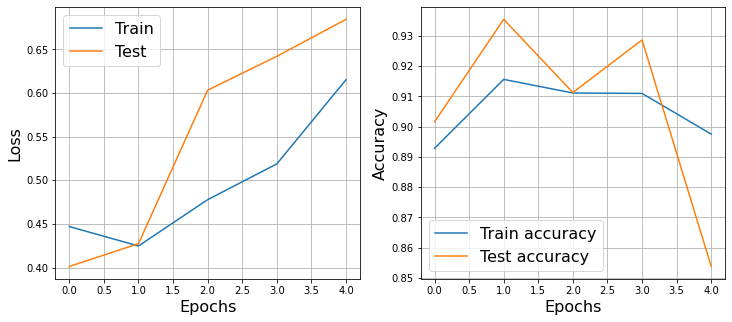

CPU times: user 1min 44s, sys: 997 ms, total: 1min 45s
Wall time: 1min 46s


In [79]:
%%time
name = 'RMSProp'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name], 
    ravel_init=True
)

Epoch 4... (Train/Test) NLL: 0.048/0.086	Accuracy: 0.984/0.975


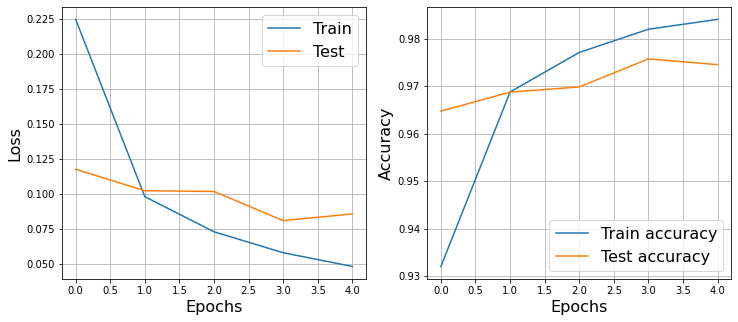

CPU times: user 1min 45s, sys: 1.99 s, total: 1min 47s
Wall time: 1min 48s


In [80]:
%%time
name = 'Adam'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name], 
    ravel_init=True
)

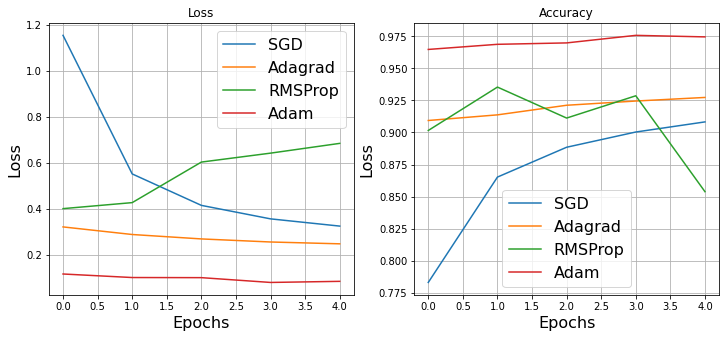

In [81]:
plot_comp(test_loss, test_accuracy)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [82]:
class ConvClassifier(nn.Module):
    def __init__(self, image_size=28, channels=1):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 3, 3, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size//2*image_size//2*3, 10), 
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [83]:
def get_nn():
    return ConvClassifier()

In [84]:
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
networks = {}
optimizers = {
    'SGD': SGD,
    'Adagrad': Adagrad,
    'RMSProp': RMSProp,
    'Adam': Adam
}

Epoch 4... (Train/Test) NLL: 0.311/0.289	Accuracy: 0.910/0.918


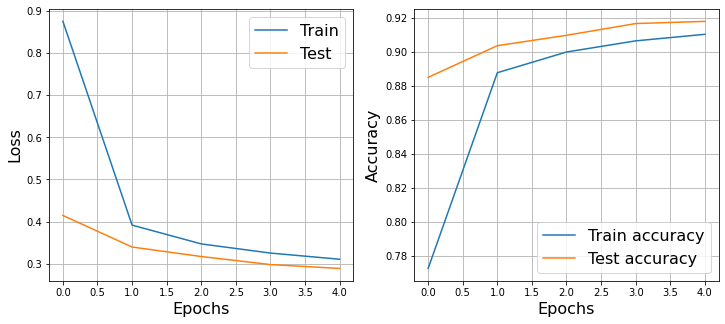

CPU times: user 1min 50s, sys: 1.56 s, total: 1min 52s
Wall time: 1min 53s


In [85]:
%%time
name = 'SGD'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name]
)

Epoch 4... (Train/Test) NLL: 0.376/0.347	Accuracy: 0.897/0.909


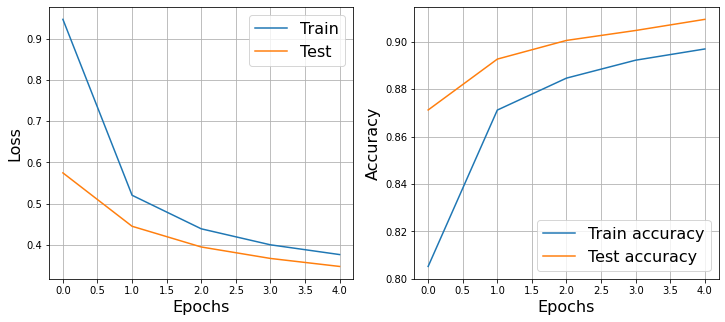

CPU times: user 1min 50s, sys: 1.49 s, total: 1min 52s
Wall time: 1min 52s


In [86]:
%%time
name = 'Adagrad'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name]
)

Epoch 4... (Train/Test) NLL: 0.134/0.122	Accuracy: 0.962/0.969


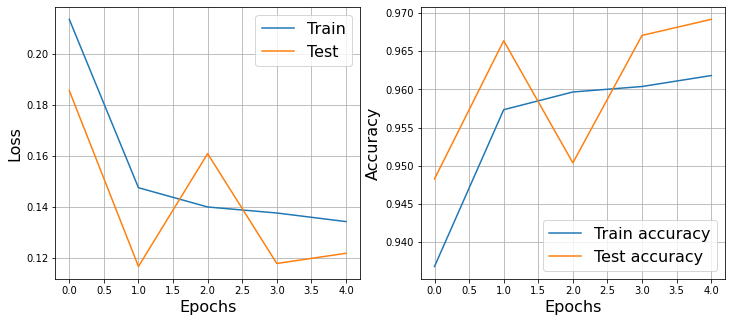

CPU times: user 1min 50s, sys: 1.48 s, total: 1min 51s
Wall time: 1min 52s


In [87]:
%%time
name = 'RMSProp'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name]
)

Epoch 4... (Train/Test) NLL: 0.084/0.086	Accuracy: 0.974/0.972


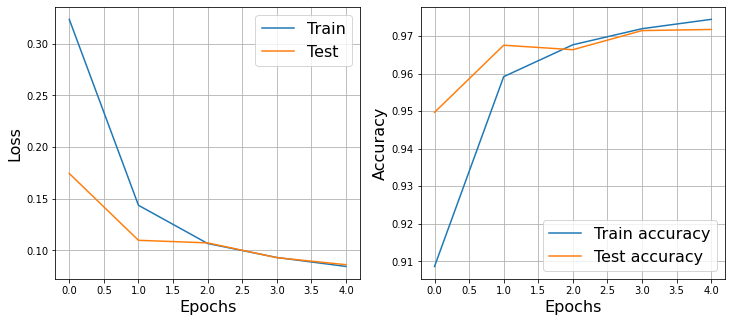

CPU times: user 1min 50s, sys: 1.41 s, total: 1min 52s
Wall time: 1min 52s


In [88]:
%%time
name = 'Adam'
networks[name] = get_nn()
train_loss[name], test_loss[name], train_accuracy[name], test_accuracy[name] = \
train(
    networks[name], 
    train_loader=base_train_loader, 
    test_loader=base_test_loader, 
    optimizer=optimizers[name]
)

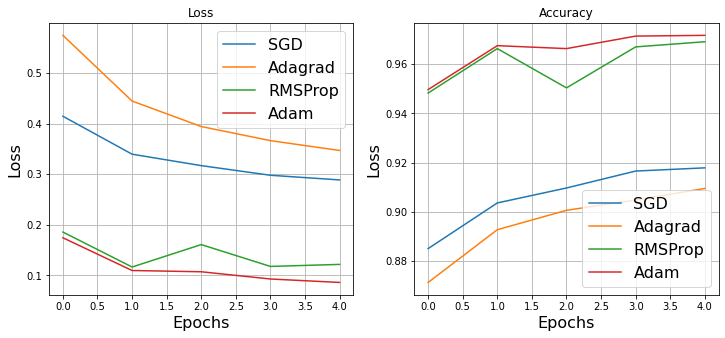

In [89]:
plot_comp(test_loss, test_accuracy)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

14 слайд

Adam: eps не под корнем

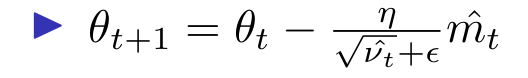

Здесь вы можете оставить комментарии по лекции или семинару: